In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy.fft as fft
from scipy import signal as scisig
from viterbi_utils import *
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

In [2]:
df_train = pd.read_pickle('../features/train_clean.pkl')
df_test = pd.read_pickle('../features/test_clean.pkl')
TARGET = "open_channels"
df_test[TARGET] = 0

df_train["group"] = df_train["batch"].astype("str") + "_" + df_train["mini_batch"].astype("str")
df_test["group"] = df_test["batch"].astype("str") + "_" + df_test["mini_batch"].astype("str")

df_train["signal_original"] = df_train["signal"].copy()
df_test["signal_original"] = df_test["signal"].copy()

print(f"train size:{df_train.shape}, test size:{df_test.shape}")
df_train.head()

train size:(4500000, 8), test size:(2000000, 9)


,time,signal,open_channels,local_time,batch,mini_batch,group,signal_original
0,0.0001,-2.7600,0,0.0001,1,1,1_1,-2.7600
1,0.0002,-2.8557,0,0.0002,1,1,1_1,-2.8557
2,0.0003,-2.4074,0,0.0003,1,1,1_1,-2.4074
3,0.0004,-3.1404,0,0.0004,1,1,1_1,-3.1404
4,0.0005,-3.1525,0,0.0005,1,1,1_1,-3.1525


In [3]:
# mini model
BATCH_GROUP = [1, 2]
df_train = df_train[df_train.batch.isin(BATCH_GROUP)].reset_index(drop=True)
TEST_GROUP = ["1_1", "1_4", "2_4", "3_1", "3_2", "3_3", "3_4", "3_5", "4_1", "4_2", "4_3", "4_4", "4_5"]
df_test = df_test[df_test.group.isin(TEST_GROUP)].reset_index(drop=True)

print(f"train size:{df_train.shape}, test size:{df_test.shape}")

train size:(1000000, 8), test size:(1300000, 9)


In [4]:
# remove the 50 hz noise using notch filter
for group_i in df_train.group.unique():

    batch_i = df_train[df_train.group.isin([group_i])]
    signal_recovered = rm_noise(batch_i, Q=60)
    df_train.loc[df_train.group.isin([group_i]), "signal"] = signal_recovered

In [5]:
viterbi_cols = ["viterbi_" + str(i) for i in range(df_train[TARGET].nunique())]
for col in viterbi_cols:
    df_train[col] = 0
    df_test[col] = 0

In [6]:
# see performance in each group
signal = df_train.loc[df_train.batch.isin(BATCH_GROUP), "signal"]
state = df_train.loc[df_train.batch.isin(BATCH_GROUP), TARGET]
viterbi = PosteriorDecoder().fit(signal, state)
for group_i in df_train.group.unique():
    batch_i = df_train[df_train.group.isin([group_i])]
    signal_i = df_train.loc[df_train.group.isin([group_i]), "signal"]
    state_i = df_train.loc[df_train.group.isin([group_i]), TARGET]
    df_train.loc[df_train.group.isin([group_i]), viterbi_cols], df_train.loc[df_train.group.isin([group_i]), "oof"] = viterbi.predict(signal_i)
    print(group_i, "F1 macro =", f1_score(y_pred=df_train.loc[df_train.group.isin([group_i]), "oof"], y_true=state_i, average='macro').round(6))

print("==> OOF F1 macro =", f1_score(y_pred=df_train["oof"].values, y_true=df_train[TARGET].values, average='macro').round(4))

1_1 F1 macro = 0.994021
1_2 F1 macro = 0.994937
1_3 F1 macro = 0.994037
1_4 F1 macro = 0.99552
1_5 F1 macro = 0.99283
2_1 F1 macro = 0.993762
2_2 F1 macro = 0.996814
2_3 F1 macro = 0.994814
2_4 F1 macro = 0.995998
2_5 F1 macro = 0.995781
==> OOF F1 macro = 0.9949


In [7]:
# predict the test
for col in TEST_GROUP:
    df_test.loc[df_test.group == col, viterbi_cols], df_test.loc[df_test.group == col, "oof"] = viterbi.predict(df_test.loc[df_test.group == col, "signal"].values)

# remove test signal noise here using oof
for group_i in TEST_GROUP:
    batch_test_i = df_test[df_test.group.isin([group_i])].copy()
    signal_test_recovered = rm_noise(batch_test_i, col="oof", Q=60)
    df_test.loc[df_test.group.isin([group_i]), "signal"] = signal_test_recovered

# re-predict test 
for group_i in TEST_GROUP:
    df_test.loc[df_test.group == group_i, viterbi_cols], df_test.loc[df_test.group == group_i, TARGET] = viterbi.predict(df_test.loc[df_test.group == group_i, "signal"].values)

In [13]:
# # save train/test oof and prediction
# np.save('hmm_oof/train_oof_model1.npy', df_train["oof"])
# np.save('hmm_oof/test_oof_model1.npy', df_test["oof"])
# np.save('hmm_pred/test_pred_model1.npy', df_test[TARGET])

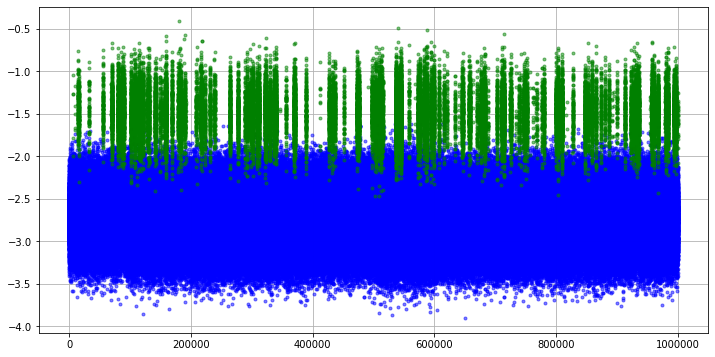

In [9]:
# train target plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.open_channels == channel_i].signal_original,
             ".",
             color=color_list[channel_i],
             alpha=0.5)

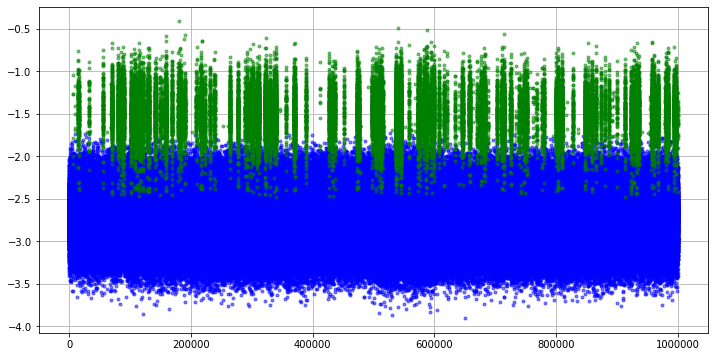

In [10]:
# train oof plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.oof == channel_i].signal_original,
             ".",
             color=color_list[channel_i],
             alpha=0.5)

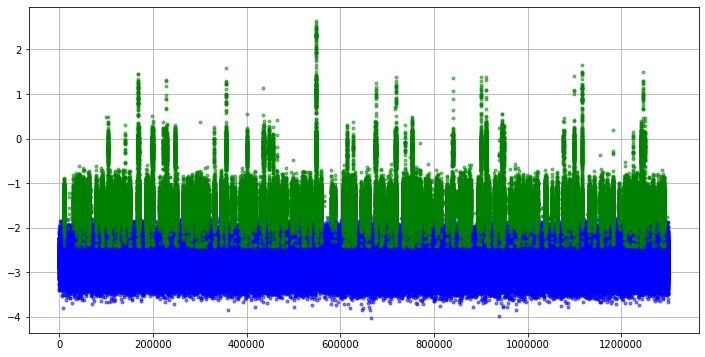

In [11]:
# test oof plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_test[(df_test.oof == channel_i)  & (df_test.group.isin(TEST_GROUP))].signal_original,
             ".",
             color=color_list[channel_i],
             alpha=0.5)
# plt.xlim([0,50000])

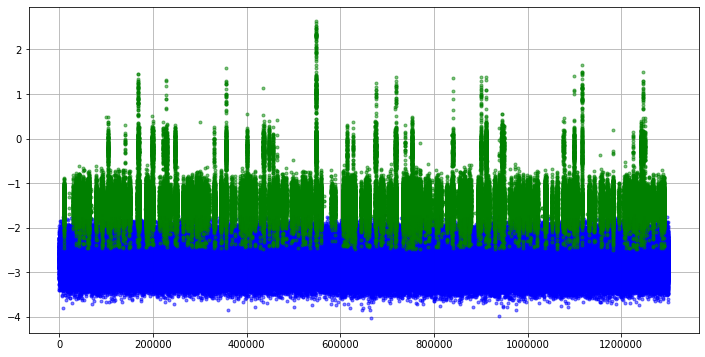

In [12]:
# test predict plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_test[(df_test.open_channels == channel_i)  & (df_test.group.isin(TEST_GROUP))].signal_original,
             ".",
             color=color_list[channel_i],
             alpha=0.5)
# plt.xlim([0,50000])